# SCP Dataset Exploration and Visualizations
## Overview
This file was created to explore various aspects of the SCP dataset in order to select interesting visualizations for the SCP Status dashboard.
## Setup

In [68]:
#!pip install pandas
#!pip install matplotlib
#!pip install dash
#!pip install plotly

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
import plotly.graph_objects as go
import plotly.express as px

In [100]:
df = pd.read_csv("scp6999augmented.csv")

## Visualizations
### Object classes

In [102]:
primary_classes=["Safe", "Euclid", "Keter"]
primary_classes_df = df[df["class"].isin(primary_classes)]

In [103]:
class_counts = primary_classes_df.groupby(["class", "series"]).count().reset_index()

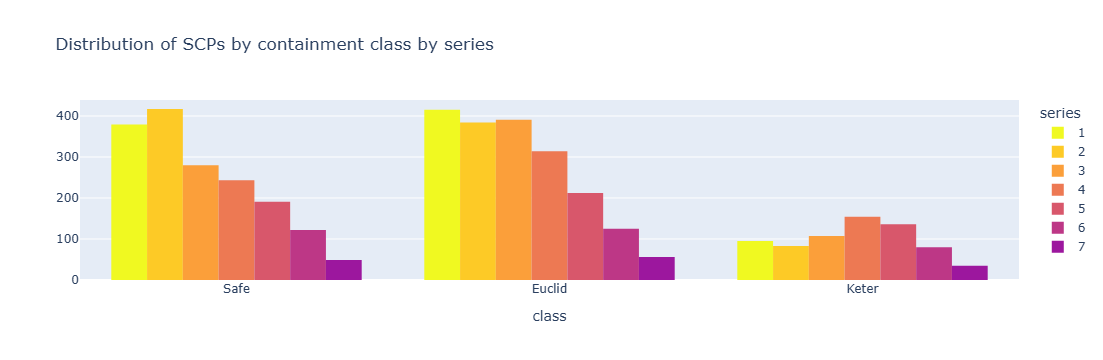

In [104]:
fig = px.histogram(class_counts, x="class", y="code", color="series", color_discrete_sequence=px.colors.sequential.Plasma_r, barmode="group",
                  title="Distribution of SCPs by containment class by series")
fig.update_xaxes(categoryorder="array", categoryarray=primary_classes)
fig.update_layout(yaxis_title="")
fig.update_traces(hovertemplate='Total SCPs: %{y}<extra></extra>')
fig.show()

## SCP mentions in other articles

In [106]:
top10 = df.sort_values(by='mentions', ascending=False).head(10)

In [110]:
top10[["code", "mentions"]]

,code,mentions
616,SCP-617,1003
457,SCP-458,783
605,SCP-606,754
299,SCP-300,733
478,SCP-479,703
501,SCP-502,697
499,SCP-500,696
309,SCP-310,691
444,SCP-445,687
300,SCP-301,682


## █ per article

In [195]:
def contains_count(string, elements):
    count = 0
    for element in elements:
        count += string.count(element)
    return count

In [197]:
black_df = df
black_df["black rectangles"] = black_df.apply(lambda row: contains_count(row["text"], ["█"]), axis=1)

In [227]:
topclasses = pd.DataFrame(df["class"].value_counts()).head(3).reset_index()
tclist = topclasses["class"].tolist()

In [229]:
tc_scps = black_df["class"].isin(tclist)
black_df = black_df[tc_scps]

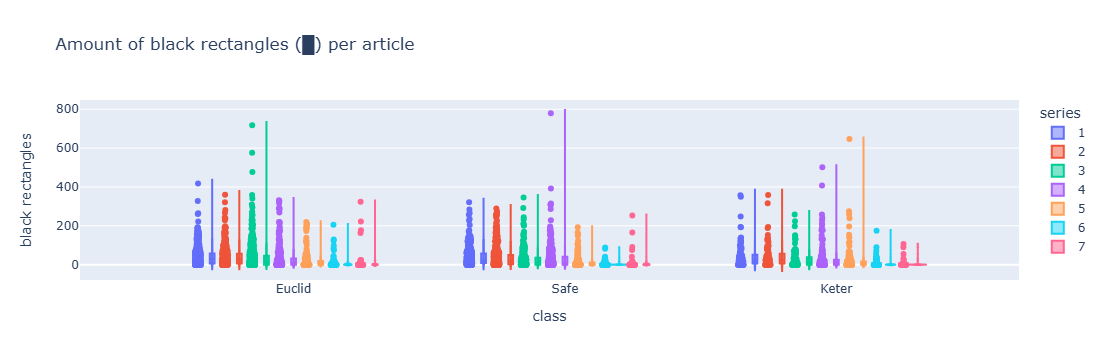

In [234]:
figure=px.violin(
            black_df,
            y="black rectangles",
            x="class",
            color="series",
            box=True,
            points="all",
            hover_data={"code":True, "title":True, "class": False, "series": False},
            title = "Amount of black rectangles (█) per article"
        )
figure.show()

## Average number of characters and popularity by class by series

In [241]:
df["length"]=df.apply(lambda row: len(row["text"]), axis=1)

In [243]:
df.describe()

,Unnamed: 0,rating,series,mentions,black rectangles,length
count,6618.000000,6611.000000,6618.000000,6618.000000,6618.000000,6618.000000
mean,3321.994107,171.366359,3.827894,32.704745,29.087186,9823.402841
std,1933.384973,257.473717,1.920317,106.884489,84.073691,9666.486295
min,0.000000,-36.000000,1.000000,-2.000000,0.000000,36.000000
25%,1654.250000,56.000000,2.000000,0.000000,0.000000,4461.500000
50%,3308.500000,107.000000,4.000000,0.000000,4.000000,7085.000000
75%,4962.750000,200.000000,5.000000,1.000000,32.000000,11739.500000
max,6998.000000,7663.000000,7.000000,1003.000000,4204.000000,211898.000000


In [263]:
ratings_df = df.dropna(subset=["rating"])
ratings_df = ratings_df[ratings_df["rating"] > 0]

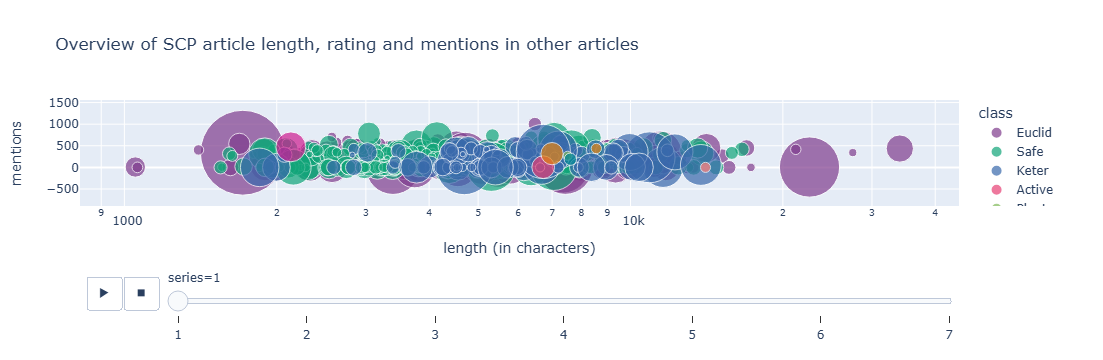

In [303]:
figure=px.scatter(
    ratings_df.dropna(subset=["rating"]),
    x="length",
    y="mentions",
    size="rating",
    color="class",
    color_discrete_sequence=px.colors.qualitative.Bold,
    hover_name="code",
    animation_frame="series",
    hover_data = {"series":False},
    log_x=True,
    size_max=60,
    title="Overview of SCP article length, rating and mentions in other articles",
)
figure.update_layout(xaxis_title="length (in characters)")
figure.show()

In [314]:
top5classes = pd.DataFrame(ratings_df["class"].value_counts()).head(5).reset_index()["class"].tolist()
top5classes

['Euclid', 'Safe', 'Keter', 'Thaumiel', 'Neutralized']

In [328]:
is_top5class = ratings_df["class"].isin(top5classes)

In [338]:
ratings_df.loc[-is_top5class, "class"] = "Other"

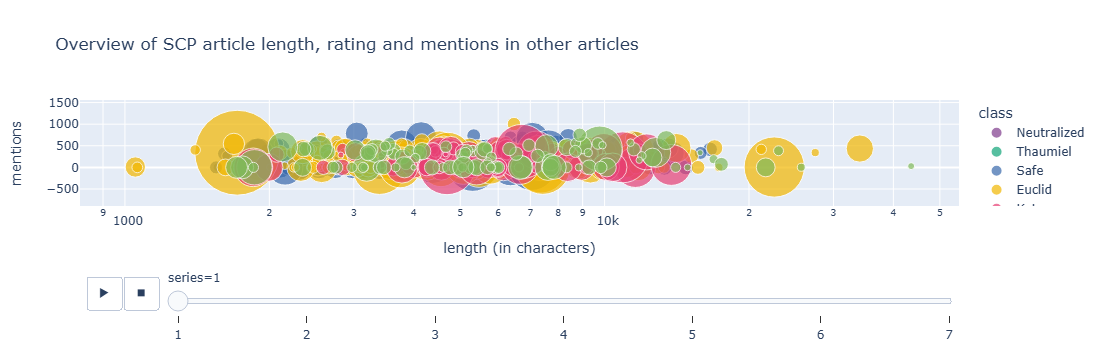

In [342]:
figure=px.scatter(
    ratings_df.dropna(subset=["rating"]),
    x="length",
    y="mentions",
    size="rating",
    color="class",
    color_discrete_sequence=px.colors.qualitative.Bold,
    hover_name="code",
    animation_frame="series",
    hover_data = {"series":False},
    log_x=True,
    size_max=60,
    title="Overview of SCP article length, rating and mentions in other articles",
    category_orders={"class": ["Neutralized", "Thaumiel", "Safe", "Euclid", "Keter", "Other"]}
)
figure.update_layout(xaxis_title="length (in characters)")
figure.show()

## Investigating negative mentions

I was originally under the impression that the `text` value provided for every SCP article contained, at the end, the code of the previous and next SCPs because the data scraped included the links to the previous and next SCP code present at the bottom of the article. I thus designed the following function to create the `mentions` column:

```
def count_mentions(code): #counts mentions of a SCP in the text column of every row except its own
    mentions = 0
    temp_df = df[df['code'] != code] # remove the SCP's own article
    for scp_text in temp_df['text']:
        mentions = mentions + scp_text.count(code)
    if code in ["SCP-001", "SCP-6999"]:
        mentions = mentions -1
    else:
        mentions = mentions - 2 # these must be substracted because at the end of each SCP article is a link to the previous and next ones
    return mentions
```

However, I must have been wrong because some SCPs currently have -1 or -2 as their `mentions` value.

In [348]:
negative_mentions_df = df[df["mentions"]<0]

In [ ]:
negative_mentions_df.describe()